In [44]:
%pip install pandas


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import sys
sys.path.append("../")

import python.utils as utils
import pandas as pd
import re

from python.constants import PATHS, CATEGORIES, TABLE_DROP_VALUES

# Tratamento Pré-análise

In [46]:
raw_data = pd.read_csv(PATHS["input"], encoding = 'utf-8')

In [47]:
pd.set_option('display.max_rows', None)
raw_data.head()
pd.reset_option('display.max_rows')

Analisando o dataset, vemos que, por diversas vezes, temos corrupção de alguns dos caracteres, que nos impedem de fazer uma importação direta pelo `dbt seed`:

In [48]:
def find_broken_substrings(df: pd.DataFrame) -> set[str]:

    broken_substrings = set()
    broken_encoding_pattern = r'\\u00[a-zA-Z0-9][a-zA-Z0-9]'

    # Procurando em cada célula do DataFrame uma substring de encoding quebrado
    df.map(
        lambda cell:
            # Caso haja atualiza a lista de encodings de caracteres quebrados
            broken_substrings.update(
                re.findall(broken_encoding_pattern, cell)
            ) if isinstance(cell, str) else None
    )

    return broken_substrings

In [49]:
find_broken_substrings(raw_data)

{'\\u00d4',
 '\\u00e1',
 '\\u00e2',
 '\\u00e3',
 '\\u00e7',
 '\\u00e9',
 '\\u00ea',
 '\\u00ed',
 '\\u00f3',
 '\\u00f4',
 '\\u00fa'}

Isto aparenta indicar que, apesar de o encoding do arquivo realmente ser em UTF-8, alguns dos valores acabaram não sendo codificados corretamente. Ao analisarmos, vemos que **todos fazem parte do conjunto Latin-1 suplementar** do UTF-8 (especificamente do subconjunto de caracteres com sinais diacríticos, como acentos e cedilha).

É possível que este erro possa ter sido causado por algum tipo de incompatibildade entre o sistema usado para os registros e a colação do banco de dados em que ele foi inserido, ou então causado por diferenças de implementação entre a codificação real na exportação os dados do BD e a plataforma em que ele foi carregado (neste caso, o Google Drive).

Como o encoding estava correto, mas estes caracteres permaneciam não decodificados, tentar decodificar novamente em UTF-8 ou em outro padrão de encoding (como Latin-1). Assim, foi necessário aplicar uma solução mais "primitiva": mapear os códigos aos seus respectivos caracteres, e então substituí-los.

Vale notar que isto claramente não seria uma solução de longo prazo para o consumo de um dataset como este em ambiente de produção. Caso isto ocorresse, idealmente deveria-se investigar o fluxo de dados da fonte (*data source*) até o depósito (*data sink*) para resolver os conflitos de encoding, ou pelo menos adicionar esta etapa ao pré-processamento antes do carregamento destes dados, mas como não é possível no contexto deste desafio, farei desta forma.

In [50]:
data = utils.correct_encoding(raw_data)

In [51]:
find_broken_substrings(data)

set()

Como visto acima, agora não há mais problemas de encoding. Agora, deveríamos ser capazes de usar o `dbt seed` para manipular propriamente a distribuição de nossos dados.

In [52]:
data.to_csv(
    path_or_buf = "../../../db_desafio/seeds/dados_ficha_fixed.csv"
)

No entanto, vê-se que, mesmo com os problemas de encoding resolvidos, a ferramenta DBT ainda tem dificuldade em importar os dados, devido ainda a problemas de encoding:

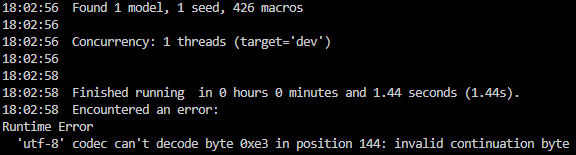

Vale notar que o decoder do Python funcionou perfeitamente, então este problema não parece ter motivo claro para ocorrer. Assim, farei a discussão da análise por este notebook, transformando o dataset durante sua exploração.

Para que o objetivo do desafio em usar o DBT não seja totalmente descartado, farei as análises de forma que o fluxo de transformações seja facilmente replicável em um modelo Python do DBT, e tentarei importar uma das duas arquiteturas finais pela ferramenta como prova de conceito.

# Analisando o dataset

Vamos analisar os tipos de dados:

In [53]:
data.dtypes

id_paciente                               object
sexo                                      object
obito                                     object
bairro                                    object
raca_cor                                  object
ocupacao                                  object
religiao                                  object
luz_eletrica                              object
data_cadastro                             object
escolaridade                              object
nacionalidade                             object
renda_familiar                            object
data_nascimento                           object
em_situacao_de_rua                        object
frequenta_escola                           int64
meios_transporte                          object
doencas_condicoes                         object
identidade_genero                         object
meios_comunicacao                         object
orientacao_sexual                         object
possui_plano_saude  

Percebe-se que temos muito mais dados de natureza categórica que numérica. Estes primeiros terão que ser explorados mais a fundo, pois alguns destes podem ser estruturados diferentemente de outros.

No entanto, antes disto, vamos apurar o "perfil" dos dados numéricos.

## Explorando dados numéricos

In [54]:
num_data = data.select_dtypes(['int64', 'float64'])

In [55]:
num_data.describe()

,frequenta_escola,altura,peso,pressao_sistolica,pressao_diastolica,n_atendimentos_atencao_primaria,n_atendimentos_hospital
count,100000.000000,99975.000000,99816.000000,99960.000000,99983.000000,100000.000000,100000.000000
mean,0.158190,142.693589,63.801629,129.544068,79.378207,5.542710,7.312930
std,0.364921,38.659345,35.594173,21.406429,21.062140,5.204464,9.801987
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,145.000000,50.700000,120.000000,70.000000,0.000000,0.000000
50%,0.000000,158.000000,67.900000,130.000000,80.000000,5.000000,2.000000
75%,0.000000,165.000000,82.000000,140.000000,87.000000,9.000000,13.000000
max,1.000000,810.000000,998.000000,900.000000,921.000000,32.000000,77.000000


### Validez dos dados

Esta visão dos dados já nos dá alguma informação. Percebemos que a maioria dos registros numéricos tem algum tipo de preenchimento, o que é bom à primeira vista, pois pode indicar que pelo menos estes dados possam ser utilizados para algum tipo de análise. Resta saber quantos dos valores preenchidos são realmente válidos.

Para este último ponto, vou redirecionar a atenção [à documentação disponibilizada pelo desafio](https://docs.google.com/spreadsheets/d/1xZKK1JJmZzWPONzpPuwAnhOYW2duwFkf/edit?gid=1923416656#gid=1923416656). Na descrição do campo *_altura_*, está registrado apenas "Altura medida". Pelos valores dos quartis do campo (25%, 50% e 75%, respectivamente), podemos inferir que está medido em centímetros, tais que o primeiro quartil seria 145 cm, o segundo 158 cm e o terceiro 165 cm. No entanto, dado este padrão, que lógica há no fato de que o valor **_máximo_** para o campo é 810?

Pode até ser de que a medida tenha sido acidentalmente registrada segundo o sistema imperial de medidas (dos EUA) devido ao paciente ter sido um estrangeiro, e sua altura real ser 8'10" (2,69 m), mas isto é altamente improvável dado que o récorde histórico de altura humana é de 8'11". Igualmente, nenhum ser humano pode pesar 900 Kg, e um coração humano é incapaz de suportar um máximo de pressão de 900 mmHg de sístole, muito menos 921 de diástole. Assim, fica claro de que alguns registros claramente são _outliers_ estatísticos devido a erros de alguma natureza (provavelmente durante o registro).

Geralmente, a forma de lidar com estes casos é manter estes registros e removê-los da consideração de um projeto através de análise estatística, mas em última instância é uma decisão a nível de arquitetura entender se eles deveriam ser mantidos ou removidos. Ademais, deveria ser associado aos registros algum tipo de documentação ou preferencialmente um metadado descrevendo as unidades de medida para cada dado numérico — percebe-se, claramente, que alguns dos campos são medições em uma escala numérica, enquanto outros, como `frequenta_escola`, são valores booleanos (verdadeiro ou falso) codificados como 0 ou 1.

Neste caso, optarei por manter um conjunto de dados maior, e deixarei estas informações conforme estão.

### Datas e valor monetário

Vale notar que os dados referentes a data-hora e a valor monetário não estão sendo considerados numéricos. No caso dos campos de data-hora, optarei por deixar assim, pois está seguindo o padrão ANSI SQL para data-hora:
```
YYYY-MM-DD hh:mm:ss
```
Como este padrão é consenso entre SGBDs e ferramentas de análise, sendo facilmente reconhecido pela vasta maioria das soluções, manterei assim.

In [56]:
data[[
    "data_cadastro",
    "data_nascimento",
    "data_atualizacao_cadastro",
    "updated_at"
]].head()

,data_cadastro,data_nascimento,data_atualizacao_cadastro,updated_at
0,2021-06-24 00:00:00.000,1996-06-25,2022-07-08 22:45:09.710,2021-06-01 00:00:00.000
1,2021-01-07 00:00:00.000,1952-12-20,2022-07-10 17:48:09.600,2020-06-25 00:00:00.000
2,2021-02-18 00:00:00.000,1931-11-14,2023-05-06 09:19:33,2020-03-02 00:00:00.000
3,2022-03-09 10:40:37,1988-12-06,2022-03-15 09:35:04.550,2021-11-05 11:08:17.477
4,2022-12-13 18:30:45,1971-01-26,2022-07-03 22:52:09,2020-11-11 00:00:00.000


Porém, com relação ao campo `renda_familiar`, há valores repetidos, além de dados incompatíveis com o valor:

In [57]:
data["renda_familiar"].unique()

array(['2 Salários Mínimos', '1 Salário Mínimo', '1/2 Salário Mínimo',
       '4 Salários Mínimos', '3 Salários Mínimos', '1/4 Salário Mínimo',
       'Mais de 4 Salários Mínimos', 'Manhã', 'Internet'], dtype=object)

No caso da incompatibilidade, nota-se que o campo na verdade não é numérico como se poderia pensar, e sim categórico com categorias bem definidas. Assim, será discutido mais à frente durante a análise dos dados catgóricos.

## Explorando dados categóricos

### Padrões diferentes para campos booleanos

Retornando ao tópico de valores booleanos, é curioso notar que, enquanto `frequenta_escola` é registrado numericamente, os seguintes campos, que também aparentam ser booleanos pelas suas descrições, são igualmente categóricos:

- `obito`
- `luz_eletrica`
- `em_situacao_de_rua`
- `possui_plano_saude`
- `familia_beneficiaria_auxilio_brasil`
- `crianca_matriculada_creche_pre_escola`

Em todos estes, assim como em `frequenta_escola`, suas descrições começam como "Indicação _se_ [...]", de onde podemos inferir que é um indicador sim/não. Vamos olhar todos estes campos ao mesmo tempo, comparando-os entre si.

In [58]:
data[[
    "obito",
    "luz_eletrica", 
    "em_situacao_de_rua", 
    "frequenta_escola", 
    "possui_plano_saude", 
    "familia_beneficiaria_auxilio_brasil", 
    "crianca_matriculada_creche_pre_escola"
]].head()

,obito,luz_eletrica,em_situacao_de_rua,frequenta_escola,possui_plano_saude,familia_beneficiaria_auxilio_brasil,crianca_matriculada_creche_pre_escola
0,0,True,0,0,False,0,0
1,0,1,0,0,1,1,0
2,0,1,0,0,0,0,0
3,False,1,0,0,0,1,1
4,0,True,0,1,0,0,0


Percebe-se que estes dados, todos de mesma natureza, não possuem padrão nenhum. Seria uma inferência relativamente segura supor que 1 ou qualquer variação de "true" ou "verdadeiro" equivaleria a um valor que indicasse verdade lógica, e que 0 ou qualquer variação de "false" ou "falso" indicasse falsidade lógica.

Assim vendo, poderíamos fazer uma etapa de conformidade, garantindo que todos estes campos sigam a mesma estrutura lógica. Contudo, é importante notar que isto deveria ser verificado tanto na documentação de cada possível fonte destes dados, quanto em possíveis versões anteriores do pipeline de dados já existente (caso já tenha sido criada anteriormente uma etapa de conformidade com regras diferentes).

Neste caso, como não sabemos qual será o SGBD utilizado para guardar estes dados, vou convertê-los em 0 e 1, pois nem todo SGBD tem um tipo `BOOLEAN` (ou algo do gênero), mas como o tipo `BIT` é definido no ANSI-SQL, praticamente todos o implementam, sendo uma solução relativamente agnóstica.

In [59]:
data = data.apply(utils.conform_booleans)

In [60]:
bool_columns = CATEGORIES["booleans"]

for col in bool_columns:
    print(data[col].unique())

[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


Ademais, possuímos mais um campo booleano: `vulnerabilidade_social`, que não possui indicação nenhuma de que seria de tal tipo (especialmente pois sua descrição é _"Vulnerabilidades sociais."_):

In [61]:
data["vulnerabilidade_social"].unique()

array([0, 1])

Vale lembrar que, apesar de estes dados serem _representados_ por números, eles são dados **categóricos**, pois sua forma original não é um valor, mas um sim ou um não.

### Dados multivalorados

In [62]:
for i in range(5):
    print(data.iloc[i])
    print('\n')

id_paciente                              cd6daa6e-038d-4952-af29-579e62e07f97
sexo                                                                     male
obito                                                                       0
bairro                                                        parada de lucas
raca_cor                                                               branca
ocupacao                                                        não se aplica
religiao                                                         sem religião
luz_eletrica                                                                1
data_cadastro                                         2021-06-24 00:00:00.000
escolaridade                                           fundamental incompleto
nacionalidade                                                      brasileira
renda_familiar                                             2 salários mínimos
data_nascimento                                                 

Percebe-se que, dentro do dataset trabalhado, possuímos alguns casos de atributos multivalorados. Nominalmente, aparenta-se que os campos multivalorados são:

- `meios_transporte`
- `doencas_condicoes`
- `meios_comunicacao`
- `em_caso_doenca_procura`

Neste caso, a solução usual, pelo menos numa arquitetura de _data warehouse_, seria coletar todos os possíveis valores de cada campo, colocá-los em uma tabela dimensão associada ao seu respectivo campo, e usar uma tabela ponte (_bridge table_) para associar aos respectivos usuários.

In [63]:
dimension_tables = {
    cat : utils.extract_unique_values(data[cat]).rename(cat)
    for cat in CATEGORIES["multivalued"]
}

In [64]:
for dim in dimension_tables.values():
    display(dim)

0     alternativo
1          animal
2       bicicleta
3        caminhão
4           carro
5         carroça
6        marítimo
7           metrô
8          outros
9            trem
10         ônibus
Name: meios_transporte, dtype: object

0                            aids
1                      alcoolismo
2                            asma
3                          câncer
4                   def. auditiva
5                     def. física
6                     def. mental
7                     def. visual
8                        diabetes
9                       epilepsia
10                       gestante
11                     hanseníase
12                    hipertensão
13    intern. psiq. ult. 12 meses
14                        malária
15                         outros
16      sintomático dermatológico
17       sintomático respiratório
18                      tabagismo
19          tentativa de suicídio
20              transtorno mental
21                    tuberculose
22     usuário de drogas ilícitas
23       usuário de psicofármacos
24            violência doméstica
Name: doencas_condicoes, dtype: object

0             3 salários mínimos
1             4 salários mínimos
2              grupos religiosos
3                       internet
4                         jornal
5     mais de 4 salários mínimos
6                          manhã
7                         outros
8                        revista
9                          rádio
10                     televisão
Name: meios_comunicacao, dtype: object

0      1 salário mínimo
1    auxílio espiritual
2              farmácia
3      hospital público
4                outros
5          rede privada
6      unidade de saúde
Name: em_caso_doenca_procura, dtype: object

Temos nossas tabelas ponte, mas claramente algumas possuem problemas, como por exemplo a resposta "1 salário mínimo" no campo `em_caso_doenca_procura`. No entanto, isto parece ser de fato como o dado se apresenta no CSV. Na linha em que ele ocorre (57210), não há campos faltantes, o que parece indicar erro humano ao preencher o campo.

Novamente temos o problema de manter ou remover os registros anômalos. Como neste caso temos campos multivalorados, acho que faz mais sentido remover a seleção destes campos anômalos, tal que se, por exemplo, um paciente tem o valor `["hospital público", "1 salário mínimo"]` no campo `em_caso_doenca_procura`, ele ficaria apenas com `["hospital público"]` em seu lugar.

Como de qualquer forma teremos que criar as tabelas ponte, vamos pontuar os registros anômalos para serem ignorados durante a criação destas. Assim, seguindo o conceito anterior, se o paciente identificado por `ABCD` tinha `["hospital público", "1 salário mínimo"]` no campo `em_caso_doenca_procura`, a tabela ponte priginalmente teria 2 registros referentes a este paciente:

| id_paciente | id_em_caso_doenca_procura |
|-------------|---------------------------|
| ABCD        | 0   _(1 salário mínimo)_  |
| ABCD        | 3   _(hospital público)_  |

Com esta mudança, restaria apenas um:

| id_paciente | id_em_caso_doenca_procura |
|-------------|---------------------------|
| ABCD        | 3                         |

Mas antes, vamos remover os valores que não fazem sentido de suas respectivas dimensões.

In [65]:
for dimension, drop_values in TABLE_DROP_VALUES["bridges"].items():
    dimension_tables[dimension] = utils.drop_by_value(
        series = dimension_tables[dimension],
        value_list = drop_values
    )

In [66]:
for v in dimension_tables.values():
    display(v)

0     alternativo
1          animal
2       bicicleta
3        caminhão
4           carro
5         carroça
6        marítimo
7           metrô
8          outros
9            trem
10         ônibus
Name: meios_transporte, dtype: object

0                            aids
1                      alcoolismo
2                            asma
3                          câncer
4                   def. auditiva
5                     def. física
6                     def. mental
7                     def. visual
8                        diabetes
9                       epilepsia
10                       gestante
11                     hanseníase
12                    hipertensão
13    intern. psiq. ult. 12 meses
14                        malária
15                         outros
16      sintomático dermatológico
17       sintomático respiratório
18                      tabagismo
19          tentativa de suicídio
20              transtorno mental
21                    tuberculose
22     usuário de drogas ilícitas
23       usuário de psicofármacos
24            violência doméstica
Name: doencas_condicoes, dtype: object

0    grupos religiosos
1             internet
2               jornal
3               outros
4              revista
5                rádio
6            televisão
Name: meios_comunicacao, dtype: object

0    auxílio espiritual
1              farmácia
2      hospital público
3                outros
4          rede privada
5      unidade de saúde
Name: em_caso_doenca_procura, dtype: object

In [67]:
bridge_tables = {
    key : utils.build_bridge_table(
        dimension_column = value,
        fact_table = data,
        fact_id_column = "id_paciente",
        fact_multival_column = key
    )
    for key, value in dimension_tables.items()
}

In [68]:
for bt in bridge_tables.values():
    print(bt.head())

                            id_paciente  id_meios_transporte
0  cd6daa6e-038d-4952-af29-579e62e07f97                   10
1  ad6cecb2-3a44-49ab-b2f3-6f9ffc2e2ec7                   10
2  54e834e7-e722-4daa-8909-cf917a1247e6                    9
3  54e834e7-e722-4daa-8909-cf917a1247e6                   10
4  54e834e7-e722-4daa-8909-cf917a1247e6                    4
                            id_paciente  id_doencas_condicoes
0  cd6daa6e-038d-4952-af29-579e62e07f97                    15
1  ad6cecb2-3a44-49ab-b2f3-6f9ffc2e2ec7                    12
2  c6a71e5e-0933-48d1-9d5a-8f448dc37f71                    15
3  4cc6a63c-61d3-49c0-807c-089c3d960956                     8
4  4cc6a63c-61d3-49c0-807c-089c3d960956                    12
                            id_paciente  id_meios_comunicacao
0  cd6daa6e-038d-4952-af29-579e62e07f97                     1
1  cd6daa6e-038d-4952-af29-579e62e07f97                     6
2  ad6cecb2-3a44-49ab-b2f3-6f9ffc2e2ec7                     1
3  ad6cecb2-3a

Agora temos nossas informações de atributos multivalorados corretamente organizadas em um esquema de _data warehouse_. Similarmente, poderíamos conformá-las em esquema de listas no esquema de um _data lake_ analítico, o que farei mais adiante após o final da análise.

### Atributos categóricos únicos

Por último, resta-nos verificar os demais atributos, que não são numéricos, nem categóricos multivalorados, restando-nos:

- Campos únicos (como nome, identificador e profissão), que podem ser complexos demais para separar em categorias bem definidas sem o uso de técnicas mais refinadas, como de NLP, por exemplo;

- Campos que, segundo nosso dataset, podem ser facilmente quebrados em categorias:
    - `sexo`
    - `bairro`
    - `raca_cor`
    - `religiao`
    - `escolaridade`
    - `nacionalidade`
    - `renda_familiar`
    - `identidade_genero`
    - `orientacao_sexual`
    - `tipo`

In [69]:
for c in CATEGORIES["well_defined"]:
    print(c)
    print(data[c].unique())
    print()

sexo
['male' 'female']

bairro
['parada de lucas' 'cidade nova' 'santa cruz' 'bangu' 'santíssimo'
 'jardim vinte e cinco de agosto' 'penha circular' 'guadalupe'
 'manguinhos' 'irajá' 'ricardo de albuquerque' 'condado de maricá'
 'anchieta' 'vila da penha' 'senador camará' 'bonsucesso' 'jacarepaguá'
 'gávea' 'realengo' 'colégio' 'tauá' 'engenho novo' 'maré' 'costa barros'
 'botafogo' 'são cristovão' 'portuguesa' 'brisa mar' 'itanhangá'
 'campo grande' 'penha' 'cavalcanti' 'olaria' 'pavuna' 'oswaldo cruz'
 'taquara' 'paciência' 'gamboa' 'cacuia' 'sampaio' 'ramos'
 'quintino bocaiuva' 'méier' 'bento ribeiro' 'bancários' 'marechal hermes'
 'guaratiba' 'vicente de carvalho' 'praça seca' 'todos os santos'
 'alto da boa vista' 'catete' 'magalhães bastos' 'cosmos' 'curicica'
 'benfica' 'vila isabel' 'praia da bandeira' 'galeão' 'barra da tijuca'
 'parque lafaiete' 'lins de vasconcelos' 'rocha miranda'
 'senador vasconcelos' 'cidade de deus' 'jacaré' 'mangueira' 'anil'
 'sepetiba' 'madureira' '

Do exposto acima, tiramos algumas conclusões:

1. Aparentemente, quando a informação não está disponível, coloca-se o valor `'não'` no seu lugar;

    - Quando há a informação mas ela não é especificada, coloca-se `'sim'`;

2. Há alguns valores que são bem difíceis de entender se deveriam estar no campo `religião`: `esb almirante`, `'10 eap 01'` e `'orquidea'`. Seria necessário perguntar aos fornecedores dos dados de que se trata, mas `'acomp. cresc. e desenv. da criança'` não parece ser um campo válido, especialmente pois `ocupação` é o campo que imediatamente antecede `religiao`;

3. Alguns destes campos, como verificamos anteriormente, estão com valores anômalos: `manhã` e `internet` no campo  `renda familiar`, que aparentemente trata de intervalos de renda;

4. Há alguma confusão no preenchimento desses dados com relação ao signficado dos campos `orientacao_sexual` e `identidade_genero`, pois há valores que deveriam estar no primeiro mas estão no segundo (`'heterossexual'`, `'homossexual (gay / lésbica)'` e `'bissexual'` são informações referentes à orientação sexual de um paciente, e não à sua identidade de gênero).


As 3 úlimas conclusões certamente nos tornam mais cientes dos problemas de qualidade deste dataset. Cmo discutido previamente, o que fazer com esses casos torna-se primeiramente uma decisão tanto de arquitetura a nível geral, e em segunda instância uma decisão de qualidade de dados a nível de projeto.

Pensando em uma arquitetura de _data warehouse_, eu optaria por mapear os valores existentes que fazem sentido para cada campo, e colocá-los em suas respectivas tabelas dimensão, substituindo as informações da tabela fato pela sua chave. Afinal, informações impertinentes dificilmente agregam valor fora de seu contexto específico, e abrem espaço para futuras inconsistências nos dados.

Já no caso de um _data lake_, normalmente se conservaria estas informações como estão, mesmo que incorretas e relativamente anômalas, pois os demais campos destes registros podem conter informações úteis para outras análises.

In [70]:
for c in CATEGORIES["well_defined"]:
    dimension_tables[c] = pd.Series(data[c].unique(), name = c)

In [71]:
for broken_category in TABLE_DROP_VALUES["dimensions"].keys():
    display(dimension_tables[broken_category])

0                           sem religião
1                             evangélica
2                               católica
3                                  outra
4                               espírita
5            religião de matriz africana
6                                    não
7                                budismo
8                               judaísmo
9                          esb almirante
10                             candomblé
11                             islamismo
12                             10 eap 01
13    acomp. cresc. e desenv. da criança
14                              orquidea
15                                   sim
Name: religiao, dtype: object

0            2 salários mínimos
1              1 salário mínimo
2            1/2 salário mínimo
3            4 salários mínimos
4            3 salários mínimos
5            1/4 salário mínimo
6    mais de 4 salários mínimos
7                         manhã
8                      internet
Name: renda_familiar, dtype: object

0                             cis
1                             não
2                           outro
3                homem transexual
4               mulher transexual
5                   heterossexual
6     homossexual (gay / lésbica)
7                       bissexual
8                             sim
9                        travesti
10                            NaN
Name: identidade_genero, dtype: object

In [72]:
for k, v in TABLE_DROP_VALUES["dimensions"].items():
    dimension_tables[k] = utils.drop_by_value(dimension_tables[k], v)

In [73]:
for broken_category in TABLE_DROP_VALUES["dimensions"].keys():
    display(dimension_tables[broken_category])

0                    sem religião
1                      evangélica
2                        católica
3                           outra
4                        espírita
5     religião de matriz africana
6                             não
7                         budismo
8                        judaísmo
9                   esb almirante
10                      candomblé
11                      islamismo
12                      10 eap 01
13                       orquidea
14                            sim
Name: religiao, dtype: object

0            2 salários mínimos
1              1 salário mínimo
2            1/2 salário mínimo
3            4 salários mínimos
4            3 salários mínimos
5            1/4 salário mínimo
6    mais de 4 salários mínimos
Name: renda_familiar, dtype: object

0                  cis
1                  não
2                outro
3     homem transexual
4    mulher transexual
5        heterossexual
6             travesti
Name: identidade_genero, dtype: object

# Estruturando os dados

## _Data Warehouse_

Uma das possíveis formas de estruturar os nossos dados, conforme dito previamente, é em uma arquitetura de _data warehouse_, que privilegia a rapidez de análise das métricas através (e, ao mesmo tempo, em detrimento) da quebra das regras de normalização presentes em arquiteturas transacionais. Ele possui tabelas fato, que estão a nível de registro individual do fato — que, no caso deste dataset, é um registro individual do paciente — e tabelas dimensão, que descrevem os vários atributos relacionados ao fato.

Assim sendo, os dados cadastrais mais "únicos", como nome, profissão etc. seriam parte do fato, e as dimensões seriam os valores associados, de natureza relativamente mais "estática" – por exemplo, o campo `sexo`, que diz respeito ao sexo biológico (no momento do nascimento) do paciente, idealmente só deveria ter dois valores possíveis: um indicando que o sexo biológico é masculino e o outro feminino. Igualmente, é muito incomum que seja criado um novo bairro.

Para os fatos multivalorados de um registro, como a lista de doenças e condições que o paciente pode ter, a tabela ponte faz o trabalho de ligar cada registro aos seus múltiplos valores associados.

Assim, para terminar de estruturar o data warehouse, basta substituir as dimensões ligadas diretamente à tabela fato, ou seja, sem ser por tabela ponte, por seus respectivos índices nas tabelas. Para os valores de dimensões que não faziam sentido (como `"manhã"` em `renda_familiar`), o valor simplesmente permanece vazio.

In [74]:
fact_table = data.copy(deep = True)

In [75]:
fact_table = utils.replace_dimensions_with_ids(
    fact_table,
    [
        dimension
        for name, dimension in dimension_tables.items()
        if name not in bridge_tables.keys()
    ]
)

In [76]:
fact_table

,id_paciente,id_sexo,obito,id_bairro,id_raca_cor,ocupacao,id_religiao,luz_eletrica,data_cadastro,id_escolaridade,id_nacionalidade,id_renda_familiar,data_nascimento,em_situacao_de_rua,frequenta_escola,meios_transporte,doencas_condicoes,id_identidade_genero,meios_comunicacao,id_orientacao_sexual,possui_plano_saude,em_caso_doenca_procura,situacao_profissional,vulnerabilidade_social,data_atualizacao_cadastro,familia_beneficiaria_auxilio_brasil,crianca_matriculada_creche_pre_escola,altura,peso,pressao_sistolica,pressao_diastolica,n_atendimentos_atencao_primaria,n_atendimentos_hospital,updated_at,id_tipo
0,cd6daa6e-038d-4952-af29-579e62e07f97,0,0,0,0,não se aplica,0,1,2021-06-24 00:00:00.000,0,0,0,1996-06-25,0,0,ônibus,"[""outros""]",0,"internet, televisão",0,0,hospital público,emprego formal,0,2022-07-08 22:45:09.710,0,0,172.0,52.5,110.0,70.0,8,9,2021-06-01 00:00:00.000,0
1,ad6cecb2-3a44-49ab-b2f3-6f9ffc2e2ec7,0,0,1,1,assistente administrativo,1,1,2021-01-07 00:00:00.000,1,0,1,1952-12-20,0,0,ônibus,hipertensão,1,"internet, televisão",0,1,[],autônomo com previdência social,0,2022-07-10 17:48:09.600,1,0,158.0,76.2,140.0,80.0,0,6,2020-06-25 00:00:00.000,0
2,54e834e7-e722-4daa-8909-cf917a1247e6,0,0,2,1,não se aplica,2,1,2021-02-18 00:00:00.000,2,0,1,1931-11-14,0,0,"carro, metrô, ônibus, trem",[],1,[],0,0,"hospital público, unidade de saúde",emprego formal,0,2023-05-06 09:19:33,0,0,53.0,82.5,180.0,60.0,5,2,2020-03-02 00:00:00.000,0
3,c6a71e5e-0933-48d1-9d5a-8f448dc37f71,1,0,3,0,representante comercial autônomo,0,1,2022-03-09 10:40:37,3,0,2,1988-12-06,0,0,"carro, ônibus","[""outros""]",1,"[""rádio"", ""televisão"", ""jornal"", ""internet""]",0,0,hospital público,não se aplica,0,2022-03-15 09:35:04.550,1,1,164.0,90.6,120.0,70.0,0,27,2021-11-05 11:08:17.477,1
4,d5262a3c-e5d3-4195-a46b-0acd2533e1d6,0,0,4,0,técnico eletricista,3,1,2022-12-13 18:30:45,4,0,1,1971-01-26,0,1,"metrô, ônibus",[],1,"[""televisão"", ""internet"", ""jornal""]",0,0,[],não trabalha,0,2022-07-03 22:52:09,0,0,154.0,8.5,180.0,80.0,25,0,2020-11-11 00:00:00.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,9aa08b9f-44f3-417d-bd1d-66288d7beaae,1,0,79,1,técnico mecânico,3,1,2021-11-21 17:17:42,3,0,0,1949-09-12,0,1,"carro, metrô, ônibus, trem",[],<NA>,"internet, jornal, rádio, televisão",0,0,"hospital público, unidade de saúde",emprego formal,0,2022-03-03 11:35:29.353,0,0,61.0,117.0,140.0,69.0,0,4,2022-04-27 14:54:01.593,0
99996,1b1f7444-8959-4210-b5de-cdfb9b62eab8,1,0,18,0,não se aplica,3,1,2021-07-28 11:17:00,0,0,4,1942-12-10,0,0,"carro, ônibus","['def. mental', 'outros']",<NA>,"internet, rádio, televisão",0,0,[],desempregado,0,2022-02-05 13:11:25.793,0,0,92.0,82.0,140.0,90.0,0,28,2020-04-15 00:00:00.000,0
99997,2c1d1127-0575-4df1-a879-12734f7cbf39,1,0,284,1,não se aplica,2,1,2022-05-18 00:00:00.000,0,0,0,2001-03-26,0,0,"bicicleta, ônibus",[],<NA>,"internet, televisão",1,0,"hospital público, unidade de saúde",não se aplica,0,2023-03-06 10:35:58.800,0,0,51.0,69.0,110.0,80.0,1,0,2022-05-18 09:24:57.333,0
99998,6a28a1d0-9d1f-4d66-8f28-759083b91f59,1,0,2,0,vendedor em domicílio,0,1,2022-05-11 11:11:51.667,4,0,4,1978-07-12,0,0,ônibus,[],<NA>,"internet, televisão",0,0,unidade de saúde,emprego formal,0,2021-10-11 00:00:00.000,0,0,163.0,91.0,150.0,80.0,0,0,2020-07-14 00:00:00.000,0


Agora que temos nossa tabela fato em ordem, basta exportar estas informações para o destino correto. Os CSVs respctivos à tabela fato e a cada tabela ponte ou dimensão estarão localizados no destino `dados/data_warehouse`.

In [77]:
destination = PATHS["output"]["dw"]
index = "id"

# Dimension tables
for dimension in dimension_tables.values():

    utils.write_to_csv(
        data_object = dimension,
        destination_path = destination,
        file_name = dimension.name,
        index_label = index,
        prefix = "dim_"
    )

# Bridge tables
for bt_name, bt_data in bridge_tables.items():

    utils.write_to_csv(
        data_object = bt_data,
        destination_path = destination,
        file_name = bt_name,
        index_label = index,
        prefix = "bt_"
    )

# Fact table
utils.write_to_csv(
    data_object = fact_table,
    destination_path = destination,
    file_name = "dados_ficha",
    index_label = index,
    prefix = "fact_"
)

## _Data Lake_

No caso de um _data lake_, o único ajuste que nos seria necessário fazer é com relação aos atributos multivalorados que, conforme dito anteriormente, deveriam ser conformados em uma mesma estrutura.

In [78]:
data_lake = data.copy(deep = True)

In [79]:
pd.set_option('display.max_columns', None)
display(data_lake.head())
pd.reset_option('display.max_columns')

,id_paciente,sexo,obito,bairro,raca_cor,ocupacao,religiao,luz_eletrica,data_cadastro,escolaridade,nacionalidade,renda_familiar,data_nascimento,em_situacao_de_rua,frequenta_escola,meios_transporte,doencas_condicoes,identidade_genero,meios_comunicacao,orientacao_sexual,possui_plano_saude,em_caso_doenca_procura,situacao_profissional,vulnerabilidade_social,data_atualizacao_cadastro,familia_beneficiaria_auxilio_brasil,crianca_matriculada_creche_pre_escola,altura,peso,pressao_sistolica,pressao_diastolica,n_atendimentos_atencao_primaria,n_atendimentos_hospital,updated_at,tipo
0,cd6daa6e-038d-4952-af29-579e62e07f97,male,0,parada de lucas,branca,não se aplica,sem religião,1,2021-06-24 00:00:00.000,fundamental incompleto,brasileira,2 salários mínimos,1996-06-25,0,0,ônibus,"[""outros""]",cis,"internet, televisão",heterossexual,0,hospital público,emprego formal,0,2022-07-08 22:45:09.710,0,0,172.0,52.5,110.0,70.0,8,9,2021-06-01 00:00:00.000,historico
1,ad6cecb2-3a44-49ab-b2f3-6f9ffc2e2ec7,male,0,cidade nova,parda,assistente administrativo,evangélica,1,2021-01-07 00:00:00.000,médio incompleto,brasileira,1 salário mínimo,1952-12-20,0,0,ônibus,hipertensão,não,"internet, televisão",heterossexual,1,[],autônomo com previdência social,0,2022-07-10 17:48:09.600,1,0,158.0,76.2,140.0,80.0,0,6,2020-06-25 00:00:00.000,historico
2,54e834e7-e722-4daa-8909-cf917a1247e6,male,0,santa cruz,parda,não se aplica,católica,1,2021-02-18 00:00:00.000,fundamental completo,brasileira,1 salário mínimo,1931-11-14,0,0,"carro, metrô, ônibus, trem",[],não,[],heterossexual,0,"hospital público, unidade de saúde",emprego formal,0,2023-05-06 09:19:33,0,0,53.0,82.5,180.0,60.0,5,2,2020-03-02 00:00:00.000,historico
3,c6a71e5e-0933-48d1-9d5a-8f448dc37f71,female,0,bangu,branca,representante comercial autônomo,sem religião,1,2022-03-09 10:40:37,alfabetizado,brasileira,1/2 salário mínimo,1988-12-06,0,0,"carro, ônibus","[""outros""]",não,"[""rádio"", ""televisão"", ""jornal"", ""internet""]",heterossexual,0,hospital público,não se aplica,0,2022-03-15 09:35:04.550,1,1,164.0,90.6,120.0,70.0,0,27,2021-11-05 11:08:17.477,rotineiro
4,d5262a3c-e5d3-4195-a46b-0acd2533e1d6,male,0,santíssimo,branca,técnico eletricista,outra,1,2022-12-13 18:30:45,médio completo,brasileira,1 salário mínimo,1971-01-26,0,1,"metrô, ônibus",[],não,"[""televisão"", ""internet"", ""jornal""]",heterossexual,0,[],não trabalha,0,2022-07-03 22:52:09,0,0,154.0,8.5,180.0,80.0,25,0,2020-11-11 00:00:00.000,historico


In [ ]:
for multi_cat in CATEGORIES["multivalued"]:
    data_lake[multi_cat] = utils.conform_multival_series(data_lake[multi_cat])

In [81]:
pd.set_option('display.max_columns', None)
data_lake.head()

,id_paciente,sexo,obito,bairro,raca_cor,ocupacao,religiao,luz_eletrica,data_cadastro,escolaridade,nacionalidade,renda_familiar,data_nascimento,em_situacao_de_rua,frequenta_escola,meios_transporte,doencas_condicoes,identidade_genero,meios_comunicacao,orientacao_sexual,possui_plano_saude,em_caso_doenca_procura,situacao_profissional,vulnerabilidade_social,data_atualizacao_cadastro,familia_beneficiaria_auxilio_brasil,crianca_matriculada_creche_pre_escola,altura,peso,pressao_sistolica,pressao_diastolica,n_atendimentos_atencao_primaria,n_atendimentos_hospital,updated_at,tipo
0,cd6daa6e-038d-4952-af29-579e62e07f97,male,0,parada de lucas,branca,não se aplica,sem religião,1,2021-06-24 00:00:00.000,fundamental incompleto,brasileira,2 salários mínimos,1996-06-25,0,0,[ônibus],[outros],cis,"[internet, televisão]",heterossexual,0,[hospital público],emprego formal,0,2022-07-08 22:45:09.710,0,0,172.0,52.5,110.0,70.0,8,9,2021-06-01 00:00:00.000,historico
1,ad6cecb2-3a44-49ab-b2f3-6f9ffc2e2ec7,male,0,cidade nova,parda,assistente administrativo,evangélica,1,2021-01-07 00:00:00.000,médio incompleto,brasileira,1 salário mínimo,1952-12-20,0,0,[ônibus],[hipertensão],não,"[internet, televisão]",heterossexual,1,[],autônomo com previdência social,0,2022-07-10 17:48:09.600,1,0,158.0,76.2,140.0,80.0,0,6,2020-06-25 00:00:00.000,historico
2,54e834e7-e722-4daa-8909-cf917a1247e6,male,0,santa cruz,parda,não se aplica,católica,1,2021-02-18 00:00:00.000,fundamental completo,brasileira,1 salário mínimo,1931-11-14,0,0,"[carro, metrô, ônibus, trem]",[],não,[],heterossexual,0,"[hospital público, unidade de saúde]",emprego formal,0,2023-05-06 09:19:33,0,0,53.0,82.5,180.0,60.0,5,2,2020-03-02 00:00:00.000,historico
3,c6a71e5e-0933-48d1-9d5a-8f448dc37f71,female,0,bangu,branca,representante comercial autônomo,sem religião,1,2022-03-09 10:40:37,alfabetizado,brasileira,1/2 salário mínimo,1988-12-06,0,0,"[carro, ônibus]",[outros],não,"[rádio, televisão, jornal, internet]",heterossexual,0,[hospital público],não se aplica,0,2022-03-15 09:35:04.550,1,1,164.0,90.6,120.0,70.0,0,27,2021-11-05 11:08:17.477,rotineiro
4,d5262a3c-e5d3-4195-a46b-0acd2533e1d6,male,0,santíssimo,branca,técnico eletricista,outra,1,2022-12-13 18:30:45,médio completo,brasileira,1 salário mínimo,1971-01-26,0,1,"[metrô, ônibus]",[],não,"[televisão, internet, jornal]",heterossexual,0,[],não trabalha,0,2022-07-03 22:52:09,0,0,154.0,8.5,180.0,80.0,25,0,2020-11-11 00:00:00.000,historico


In [82]:
utils.write_to_csv(
    data_object = data_lake,
    destination_path = PATHS["output"]["dl"],
    file_name = "dados_ficha",
    prefix = "datalake_"
)

# Mockups de modelos DBT

Conforme dito no início, exportarei o _data lake_ para a pasta `seeds` do projeto DBT, na tentativa de consumi-lo para dentro de um banco de dados.

In [83]:
utils.write_to_csv(
    data_object = data_lake,
    destination_path = PATHS["dbt"],
    file_name = "dados_ficha",
    prefix = "datalake_"
)

Ainda assim, ocorreu o mesmo problema de encoding durante sua importação. Apesar dos problemas logo na primeira etapa de importação, o fluxo de transformação apresentado durante a discussão é facilmente replicável para modelos Python do DBT, recriando as arquiteturas de dados descritas sem muito esforço devido à modularização das funções e cosntantes.

Abaixo, apresento mockups de como seriam os modelos Python para cada tipo de arquitetura e tabela.

## _Data Warehouse_

Obs.: Como o DBT não permite exportar uma tabela por vez, seria necessário repetir o fluxo de tabela ponte ou tabela dimensão para cada uma, adaptando os valores necessários.

### Tabela fato

```python
import pandas as pd
import dbt
import python.utils as utils
from python.constants import CATEGORIES, TABLE_DROP_VALUES

def model(dbt, session):

    data = dbt.ref("dados_ficha_a_desafio").to_pandas()

    fact_table = data.apply(utils.conform_booleans)

    dimension_tables = {
        cat : utils.extract_unique_values(data[cat]).rename(cat)
        for cat in CATEGORIES["multivalued"]
    }

    for dimension, drop_values in TABLE_DROP_VALUES["bridges"].items():
        dimension_tables[dimension] = utils.drop_by_value(
            series = dimension_tables[dimension],
            value_list = drop_values
        )

    for c in CATEGORIES["well_defined"]:
        dimension_tables[c] = pd.Series(data[c].unique(), name = c)

    for k, v in TABLE_DROP_VALUES["dimensions"].items():
        dimension_tables[k] = utils.drop_by_value(dimension_tables[k], v)

    bridge_tables = {
        key : utils.build_bridge_table(
            dimension_column = value,
            fact_table = data,
            fact_id_column = "id_paciente",
            fact_multival_column = key
        )
        for key, value in dimension_tables.items()
    }

    fact_table = utils.replace_dimensions_with_ids(
        fact_table,
        [
            dimension
            for name, dimension in dimension_tables.items()
            if name not in bridge_tables.keys()
        ]
    )

    return fact_table
```

### Tabela ponte (ex. `renda_familiar`)

```python
import pandas as pd
import dbt
import python.utils as utils
from python.constants import TABLE_DROP_VALUES

def model(dbt, session):

    data = dbt.ref("dados_ficha_a_desafio").to_pandas()

    dimension = "renda_familiar"

    dimension_table = utils.extract_unique_values(data[dimension]).rename(dimension)

    dimension_table = utils.drop_by_value(
        series = dimension_tables[dimension],
        value_list = TABLE_DROP_VALUES["dimensions"][dimension]
    )

    bridge_table = utils.build_bridge_table(
        dimension_column = dimension_table,
        fact_table = data,
        fact_id_column = "id_paciente",
        fact_multival_column = dimension
    )

    return bridge_table
```

### Tabela dimensão (ex. `renda_familiar`)

```python
import pandas as pd
import dbt
import python.utils as utils
from python.constants import TABLE_DROP_VALUES

def model(dbt, session):

    data = dbt.ref("dados_ficha_a_desafio").to_pandas()

    dimension = "renda_familiar"

    dimension_table = utils.extract_unique_values(data[dimension]).rename(dimension)

    dimension_table = utils.drop_by_value(
        series = dimension_tables[dimension],
        value_list = TABLE_DROP_VALUES["dimensions"][dimension]
    )

    return dimension_table
```

## _Data Lake_

```python
import pandas as pd
import dbt
import python.utils as utils
from python.constants import CATEGORIES

def model(dbt, session):

    data_lake = dbt.ref("dados_ficha_a_desafio").to_pandas()

    for multi_cat in CATEGORIES["multivalued"]:
        data_lake[multi_cat] = utils.conform_multival_series(data_lake[multi_cat])

    return data_lake
```